In [1]:
!pip install seaborn==0.9.0

In [59]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

SEED = 20
np.random.seed(SEED) # Fazendo isso, não será necessário passar o random_state no LinearSVC muito menos no train_test_split

map = {"unfinished": "Não Finalizado", "expected_hours": "Horas Esperadas", "price": "Preço"}
dados = pd.read_csv('./data/projects.csv')
dados.rename(columns = map, inplace=True)

dados["Finalizado"] = dados["Não Finalizado"].map({0:1, 1:0})
del dados["Não Finalizado"]
dados.head()

,Horas Esperadas,Preço,Finalizado
0,26,192,0
1,88,9015,0
2,89,2577,0
3,42,275,0
4,39,170,0


# Plotando Valores com Seaborn

Utilizano o `Seaborn#scatterplot` é possível plottar e definir a cor de acordo com um dado

<AxesSubplot:xlabel='Horas Esperadas', ylabel='Preço'>

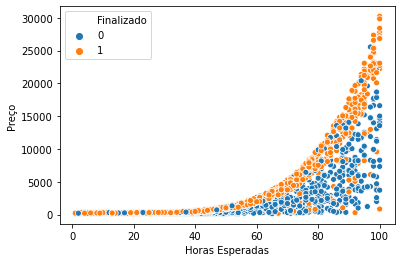

In [60]:
import seaborn as sns

sns.scatterplot(x="Horas Esperadas", y="Preço", hue="Finalizado", data=dados)

Utilizando o `Seaborn#relplot` é possivel plottar mais de um gráfico para cada coluna semelhante

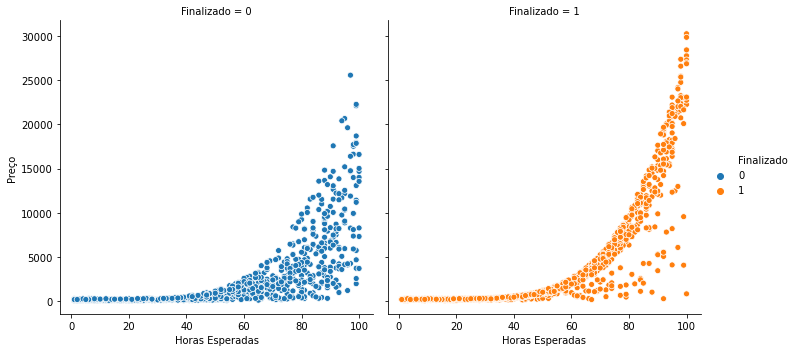

In [61]:
sns.relplot(x="Horas Esperadas", y="Preço", hue="Finalizado", col="Finalizado", data=dados)

In [76]:
x = dados[["Horas Esperadas", "Preço"]]
y = dados["Finalizado"]

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size=0.25, stratify=y)
print("Treinar com %d e testar com %d" % (len(treino_x), len(teste_x)))

model = LinearSVC(dual=False, random_state=SEED)
model.fit(treino_x, treino_y)
predict = model.predict(teste_x)

acuracia = accuracy_score(teste_y, predict) * 100
print("Acurácia: %.2f%%" % acuracia)

Treinar com 1617 e testar com 540
Acurácia: 50.93%


In [55]:
linha_de_base = np.ones(len(teste_x))
acuracia = accuracy_score(teste_y, linha_de_base) * 100
print("Acurácia do algoritmo de baseline foi de: %.2f%%" % acuracia)

Acurácia do algoritmo de baseline foi de: 52.59%


# Analisar o que foi feito de errado

De acordo com os resultados: utilizando a LinearSVC, em comparação com um de **baseline**, houve uma melhora muito pequena.  
Aqui será feita a analise utilizando o Seaborn para entender o que está incorreto.

<AxesSubplot:xlabel='Horas Esperadas', ylabel='Preço'>

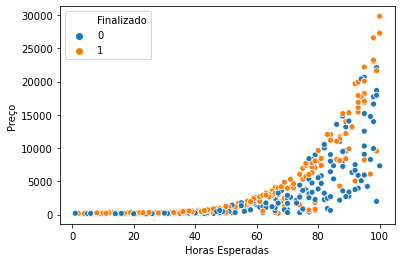

In [77]:
sns.scatterplot(x="Horas Esperadas", y="Preço", hue=teste_y, data=teste_x)

Aparentemente, não há erros nos dados de teste, todos estão de acordo com o esperado.  
Abaixo utilizaremos o `Matplotlib` para plottar todos as possiveis saidas para todas as possiveis entradas na nossa Rede Neural:

In [85]:
x_min = teste_x["Horas Esperadas"].min()
x_max = teste_x["Horas Esperadas"].max()
y_min = teste_x["Preço"].min()
y_max = teste_x["Preço"].max()

pixels = 100
x_range = np.arange(x_min, x_max, (x_max - x_min) / pixels)
y_range = np.arange(y_min, y_max, (y_max - y_min) / pixels)

# Multiplicar (área) Eixo X com Eixo Y
xx, yy = np.meshgrid(x_range, y_range)
hora_preco = np.c_[xx.ravel(), yy.ravel()]

Z = model.predict(hora_preco)
Z = Z.reshape(xx.shape)

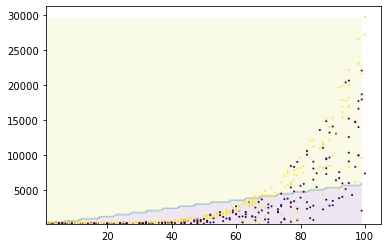

In [86]:
import matplotlib.pyplot as plt

plt.contourf(xx, yy, Z, alpha=0.1)
plt.scatter(teste_x["Horas Esperadas"], teste_x["Preço"], c=teste_y, s=1)

# DECISION BOUNDARY (Curva de decisão)

Aqui é possível perceber que foi traçado uma RETA (Linear), é por este motivo que o algoritmo está tão ruim.  
Logo, devemos utilizar um estimador **capaz** de acompanhar esta curva, um **Estimador não-linear**.

# Arrumando a Rede Neural

Aqui utilizaremos o `SVC` (e não o `LinearSVC`).

In [93]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

SEED = 20
np.random.seed(SEED) # Fazendo isso, não será necessário passar o random_state no LinearSVC muito menos no train_test_split

map = {"unfinished": "Não Finalizado", "expected_hours": "Horas Esperadas", "price": "Preço"}
dados = pd.read_csv('./data/projects.csv')
dados.rename(columns = map, inplace=True)

dados["Finalizado"] = dados["Não Finalizado"].map({0:1, 1:0})
del dados["Não Finalizado"]
x = dados[["Horas Esperadas", "Preço"]]
y = dados["Finalizado"]

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size=0.25, stratify=y)
print("Treinar com %d e testar com %d" % (len(treino_x), len(teste_x)))

model = SVC()
model.fit(treino_x, treino_y)
predict = model.predict(teste_x)

acuracia = accuracy_score(teste_y, predict) * 100
print("Acurácia: %.2f%%" % acuracia)

Treinar com 1617 e testar com 540
Acurácia: 53.15%


Deu bom não... Vamos ver a **Curva de Decisão** (Decision Boundary) do SVC desta vez.

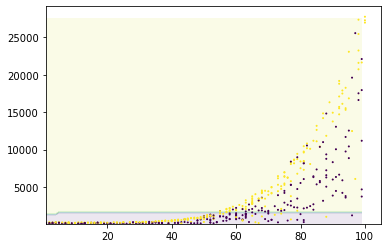

In [94]:
x_min = teste_x["Horas Esperadas"].min()
x_max = teste_x["Horas Esperadas"].max()
y_min = teste_x["Preço"].min()
y_max = teste_x["Preço"].max()

pixels = 100
x_range = np.arange(x_min, x_max, (x_max - x_min) / pixels)
y_range = np.arange(y_min, y_max, (y_max - y_min) / pixels)

xx, yy = np.meshgrid(x_range, y_range)
hora_preco = np.c_[xx.ravel(), yy.ravel()]

Z = model.predict(hora_preco)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.1)
plt.scatter(teste_x["Horas Esperadas"], teste_x["Preço"], c=teste_y, s=1)

O SVC é sensível a escala, justamente pois agora não é mais uma reta,  
Vamos tentar padronizar esses dados para ficar em uma faixa de escala similar para que o algoritmo possa aprender corretamente.

# Reescalando os dados (Pré-processamento)

In [103]:
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

SEED = 20
np.random.seed(SEED)

map = {"unfinished": "Não Finalizado", "expected_hours": "Horas Esperadas", "price": "Preço"}
dados = pd.read_csv('./data/projects.csv')
dados.rename(columns = map, inplace=True)

dados["Finalizado"] = dados["Não Finalizado"].map({0:1, 1:0})
del dados["Não Finalizado"]
x = dados[["Horas Esperadas", "Preço"]]
y = dados["Finalizado"]

raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size=0.25, stratify=y)
print("Treinar com %d e testar com %d" % (len(raw_treino_x), len(raw_teste_x)))

scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

model = SVC()
model.fit(treino_x, treino_y)
predict = model.predict(teste_x)

acuracia = accuracy_score(teste_y, predict) * 100
print("Acurácia: %.2f%%" % acuracia)

Treinar com 1617 e testar com 540
Acurácia: 70.37%


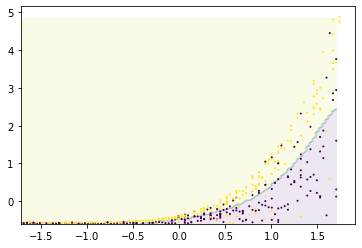

In [104]:
data_x = teste_x[:, 0] # Já que agora é um array numpy e não um DataFrame do pandas
data_y = teste_x[:, 1] # é necessário pegar o valor diretamente

x_min = data_x.min()
x_max = data_x.max()
y_min = data_y.min()
y_max = data_y.max()

pixels = 100
x_range = np.arange(x_min, x_max, (x_max - x_min) / pixels)
y_range = np.arange(y_min, y_max, (y_max - y_min) / pixels)

xx, yy = np.meshgrid(x_range, y_range)
hora_preco = np.c_[xx.ravel(), yy.ravel()]

Z = model.predict(hora_preco)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.1)
plt.scatter(data_x, data_y, c=teste_y, s=1)